In [1]:
library(tidyverse)
library(DESeq2)
library(BiocParallel)
library(ggrepel)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects

In [2]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

# Constants

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
dsets <- c("unified_cervical_data")
dset_paths <- unlist(map(dsets, function(d) paste0(dirs$data_dir, "/", d)))
matrisome_list <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")
dset_idx <- 1
                         
padj_thresh <- 0.05
expr_thresh <- 0

# Functions

In [25]:
run_DESeq_and_get_results <- function(dds) {
    #We want results without outlier removal or independent filtering since filtering should happen downstream.
    #See docs: https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#how-can-i-get-unfiltered-deseq2-results
    dds_seq <- DESeq(dds, parallel = TRUE)
    res <- results(
        dds_seq,
        contrast = c("condition", "tumor", "healthy"),
        pAdjustMethod = "BH",
        alpha = padj_thresh,
        parallel = TRUE
    )
    return(as_tibble(res, rownames = "geneID"))
}


get_group_samples <- function(counts_df, coldata_df, sample_group) {
    if (sample_group == "GTEX") {
        group_samples <- (coldata_df %>%
            dplyr::filter(data_source == "GTEx"))$sample_name
    }
    else if (sample_group == "TCGA_healthy") {
        group_samples <- (coldata_df %>%
            dplyr::filter(condition == "healthy" & data_source == "TCGA"))$sample_name
    }
    else if (sample_group == "TCGA_tumor") {
        group_samples <- (coldata_df %>%
            dplyr::filter(condition == "tumor"))$sample_name
    }
    
    return(counts_df %>% dplyr::select("geneID", all_of(group_samples)))
}


get_thresh_results <- function(group_df, thresh, group_name) {
    over_thresh_str <- paste0(group_name, "_over_thresh")
    over_thresh_prop_str <- paste0(group_name, "_over_thresh_prop")

    res_df <- group_df %>%
        mutate(over_thresh = rowSums(. [, -1] > thresh)) %>%
        mutate(over_thresh_prop = over_thresh / (ncol(.) - 2)) %>%
        dplyr::rename(!!over_thresh_str := over_thresh) %>%
        dplyr::rename(!!over_thresh_prop_str := over_thresh_prop) %>%
        dplyr::select(matches(c("geneID", over_thresh_str, over_thresh_prop_str)))
    return(res_df)
}


get_thresh_results_for_all <- function(counts_df, coldata_df, group_names, thresh) {
    df_list <- list()
    for (gn in group_names) {
        group_counts_df <- get_group_samples(counts_df, coldata_df, gn)
        thresh_res_df <- get_thresh_results(group_counts_df, thresh, gn)
        df_list[[gn]] <- thresh_res_df
    }
    final_df <- df_list %>%
        purrr::reduce(inner_join, by = "geneID") %>%
        mutate(
            tot_over_thresh = rowSums(select(., paste0(group_names, "_over_thresh"))),
            tot_over_thresh_prop = tot_over_thresh / (ncol(counts_df) - 1)    # subtract 1 because we assume gene names is a column
        )
    return(final_df)
}


to_vplot_df <- function(df) {
    vplot_df <- df %>%
        dplyr::rename(log2_fc = log2FoldChange) %>%
        dplyr::rename(gene_ID = geneID) %>%
        dplyr::rename(base_mean = baseMean) %>%
        dplyr::mutate(neg_log10_padj = -log10(padj)) %>%
        dplyr::select(gene_ID, base_mean, log2_fc, neg_log10_padj, padj, pvalue)
    return(vplot_df)
}


make_vplot <- function(df, add_contour = FALSE, jitter_w = 0, jitter_h = 0, abs_log2_fc_outlier_thresh = 15) {
    lfc_outliers_df <- df %>%
        dplyr::filter(abs(log2_fc) > abs_log2_fc_outlier_thresh)
    
    plt <- ggplot() +
        geom_point(data = df, aes(y = neg_log10_padj, x = log2_fc), size = 0.25, position = position_jitter(w = jitter_w, h = jitter_h)) +
        {if (nrow(lfc_outliers_df) > 0) geom_label_repel(data = lfc_outliers_df, aes(label = gene_ID, y = neg_log10_padj, x = log2_fc), size = 2)} +
        {if (add_contour) geom_density2d(aes(colour=..level..))} +
        {if (add_contour) scale_colour_gradient(low = "#00e600", high="#cc0000", name = "Density")} +
        geom_hline(yintercept = -log10(0.05), linetype = "longdash", colour = "#737373", size = 0.5) +
        geom_vline(xintercept = log2(2), linetype = "longdash", colour = "#BE684D", size = 0.5) +
        geom_vline(xintercept = -1, linetype = "longdash", colour = "#2C467A", size = 0.5) +
        labs(title = "Matrisome DEG Analysis",
            subtitle = "CESC") +
        xlab("log2 fold-change") +
        ylab("-log10(adj. p-val)") +
        guides(alpha="none")

    return(plt)
}

# Read in data

In [5]:
counts_df <- read_tsv(paste0(dset_paths[dset_idx], "/counts.tsv")) %>%
    mutate_if(is.numeric, round, 0) %>%
    dplyr::select(-Entrez_Gene_Id) %>%
    dplyr::rename(geneID = Hugo_Symbol)
coldata_df <- read_tsv(paste0(dset_paths[dset_idx], "/coldata.tsv"))
all(coldata_df$sample_name == colnames(counts_df[, -1]))

matrisome_genes_df <- rutils::load_matrisome_df(matrisome_list) %>%
    dplyr::select(gene_symbol)

Parsed with column specification:
cols(
  .default = col_double(),
  Hugo_Symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  data_source = col_character()
)


[1] TRUE

Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


In [6]:
sum(coldata_df$condition == "healthy")
sum(coldata_df$condition == "tumor")

[1] 13

[1] 259

# Pre-filter

In [16]:
all_counts_res_df <- get_thresh_results_for_all(
    counts_df,
    coldata_df,
    c("GTEX", "TCGA_healthy", "TCGA_tumor"),
    thresh = 0
)


# sufficiently_expr_genes_df <- all_counts_res_df %>%
#     dplyr::filter(
#         GTEX_over_thresh_prop > min_prop &
#         TCGA_healthy_over_thresh_prop > min_prop &
#         TCGA_tumor_over_thresh_prop > min_prop
#     )

sufficiently_expr_genes_df <- all_counts_res_df %>%
    dplyr::filter(tot_over_thresh_prop > 1/3)

# sufficiently_expr_genes_df <- all_counts_res_df %>%
#     dplyr::filter((GTEX_over_thresh + TCGA_healthy_over_thresh) > (1 / 3 * sum(coldata_df$condition == "healthy"))) %>%
#     dplyr::filter(TCGA_tumor_over_thresh_prop > 0.5)

nrow(sufficiently_expr_genes_df)
# Proportion of genes which will be kept
nrow(sufficiently_expr_genes_df) / nrow(counts_df)

[1] 17961

[1] 0.8873135

In [17]:
head(all_counts_res_df)
dim(all_counts_res_df)

geneID,GTEX_over_thresh,GTEX_over_thresh_prop,TCGA_healthy_over_thresh,TCGA_healthy_over_thresh_prop,TCGA_tumor_over_thresh,TCGA_tumor_over_thresh_prop,tot_over_thresh,tot_over_thresh_prop
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FAM208A,11,1.0000000,2,1.0,259,1.000000,272,1.0000000
RADIL,11,1.0000000,2,1.0,258,0.996139,271,0.9963235
AP1M2,11,1.0000000,2,1.0,259,1.000000,272,1.0000000
TAF1,11,1.0000000,2,1.0,259,1.000000,272,1.0000000
SIGLEC5,10,0.9090909,2,1.0,247,0.953668,259,0.9522059
KLF1,4,0.3636364,1,0.5,247,0.953668,252,0.9264706


[1] 20242     9

In [18]:
filtered_counts_df <- counts_df %>%
    dplyr::filter(geneID %in% sufficiently_expr_genes_df$geneID)

# Run DGE Analysis

In [19]:
dds <- DESeqDataSetFromMatrix(
    countData = filtered_counts_df %>% column_to_rownames(var = "geneID"),
    colData = coldata_df %>% column_to_rownames(var = "sample_name"),
#     design = ~ data_source + condition
    design = ~ condition
)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

In [20]:
dge_res <- run_DESeq_and_get_results(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 14 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 14 workers
-- replacing outliers and refitting for 1899 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


Saving 6.67 x 6.67 in image


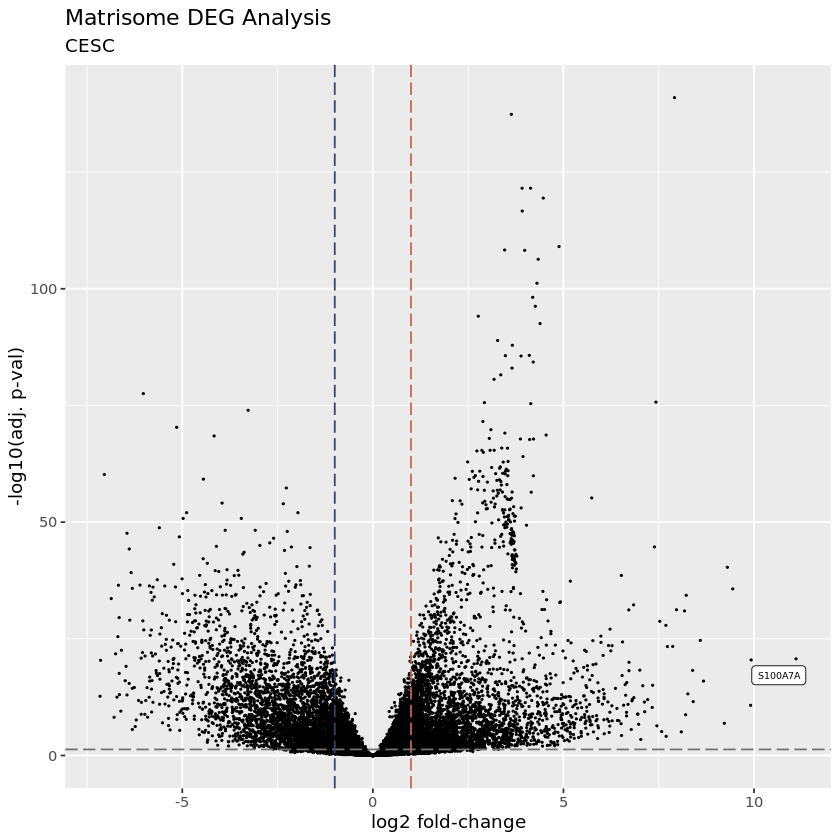

In [26]:
dge_res %>%
    to_vplot_df %>%
    make_vplot(abs_log2_fc_outlier_thresh = 10)
ggsave("all_genes_vplot.png", last_plot())

Saving 6.67 x 6.67 in image


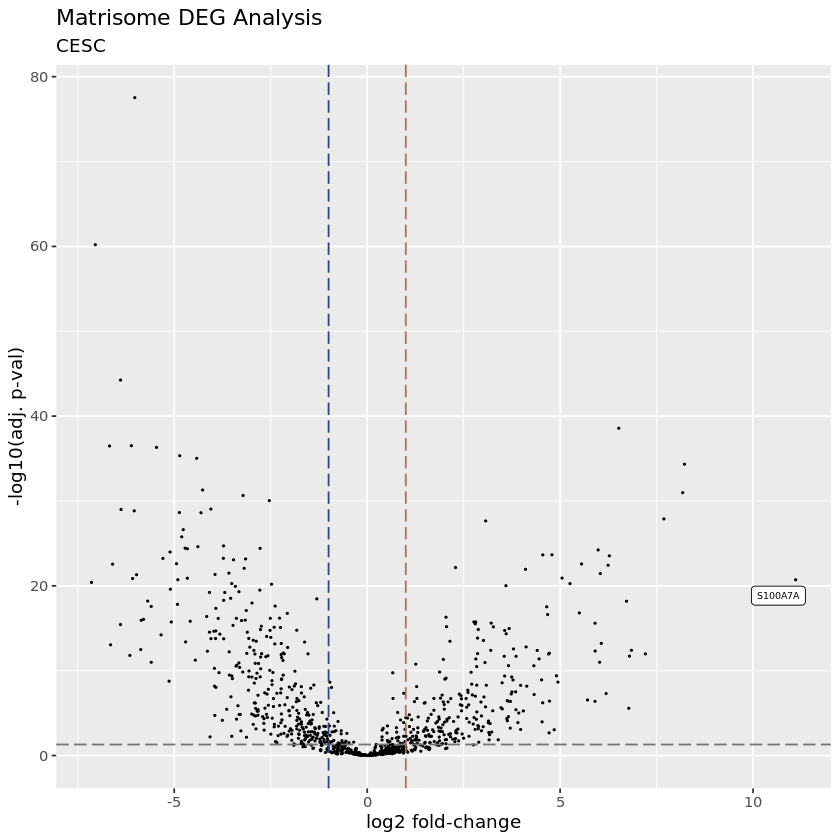

In [27]:
dge_res %>%
    inner_join(matrisome_genes_df, by = c("geneID" = "gene_symbol")) %>%
    to_vplot_df %>%
    make_vplot(abs_log2_fc_outlier_thresh = 10)

ggsave("matrisome_genes_vplot.png", last_plot())

In [32]:
dge_res %>%
    inner_join(matrisome_genes_df, by = c("geneID" = "gene_symbol")) %>%
    dplyr::filter(abs(log2FoldChange) > log2(4) & padj < 0.05)

geneID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TIMP4,49.579600,-4.453963,0.6221998,-7.158413,8.161663e-13,5.769052e-12
PRL,4.336559,-3.272308,0.9516858,-3.438434,5.850902e-04,1.246596e-03
OGN,586.195062,-6.392699,0.7572341,-8.442170,3.115010e-17,3.630674e-16
NDNF,108.934901,-2.060176,0.6675442,-3.086202,2.027308e-03,3.928840e-03
CCL22,396.348714,3.678745,0.4428371,8.307219,9.797113e-17,1.078884e-15
ANGPTL7,26.357563,-7.144394,0.7337261,-9.737141,2.093620e-22,4.026071e-21
MUC3A,192.446118,3.253996,0.6794070,4.789464,1.672272e-06,5.344427e-06
S100P,8601.652920,5.498087,0.6234255,8.819156,1.153255e-18,1.563292e-17
SFRP1,4465.365567,-2.462176,0.5678949,-4.335620,1.453498e-05,4.014497e-05
